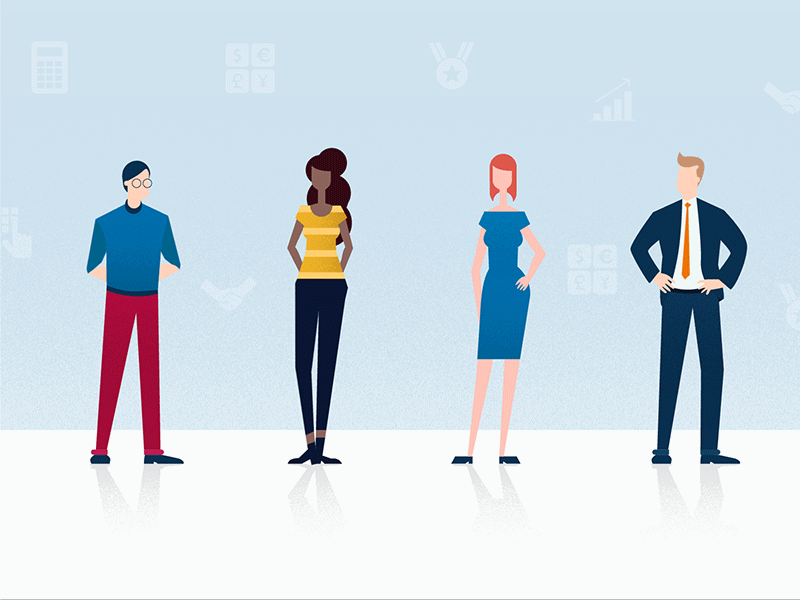

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Feature Selection

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Importing Libraries

In [1]:
import numpy  as np
import polars as pl
import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',None)
#pd.set_option('future.no_silent_downcasting',True)

#pip install modin[all]
#pip install --upgrade ipywidgets
#import modin.pandas as mpd
#import os; os.environ["MODIN_CPUS"] = "2"

#pip install lightgbm
#pip install --upgrade "lightgbm[pandas]"
#pip install --upgrade pandas dask "dask[complete]"
#pip install --upgrade modin
import lightgbm as lgb

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics         import r2_score
from scipy.stats             import shapiro

import time, pickle, random
t_init = time.time()


import warnings 
#warnings.filterwarnings('ignore') 

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> functions

In [2]:
def Optimize_dtypes(data):
    for ft in data.columns:
        try:
            data = data.with_columns( pl.col(ft).cast(pl.Int8) )
        except:
            try:
                data = data.with_columns( pl.col(ft).cast(pl.Int16) )
            except:
                try:
                    data = data.with_columns( pl.col(ft).cast(pl.Int32) )
                except:
                    try:
                        data = data.with_columns( pl.col(ft).cast(pl.Int64) )
                    except:
                        try:
                            data = data.with_columns( pl.col(ft).cast(pl.Float32) )
                        except:
                            try:
                                data = data.with_columns( pl.col(ft).cast(pl.Float64) )
                            except:
                                ;
    return data

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading DataSet

In [3]:
data = pickle.load( open('Data_Clean','rb') )  # load
data = Optimize_dtypes(data)
data.tail()

shape: (5, 25)
┌─────┬────────────────┬────────────────┬────────┬───┬────────────────┬────────────────┬───────────────┬───────────────┐
│ Age ┆ Avg_Account_Ba ┆ Credit_Product ┆ Gender ┆ … ┆ Region_Code_P0 ┆ Region_Code_P0 ┆ Region_Code_P ┆ Region_Code_P │
│ --- ┆ lance          ┆ ---            ┆ ---    ┆   ┆ 25             ┆ 50             ┆ 075           ┆ 100           │
│ i8  ┆ ---            ┆ str            ┆ str    ┆   ┆ ---            ┆ ---            ┆ ---           ┆ ---           │
│     ┆ i32            ┆                ┆        ┆   ┆ i8             ┆ i8             ┆ i8            ┆ i8            │
╞═════╪════════════════╪════════════════╪════════╪═══╪════════════════╪════════════════╪═══════════════╪═══════════════╡
│ 67  ┆ 467276         ┆ No             ┆ Male   ┆ … ┆ 19             ┆ 31             ┆ 25            ┆ 23            │
│ 63  ┆ 594475         ┆ No             ┆ Female ┆ … ┆ 19             ┆ 22             ┆ 27            ┆ 30            │
│ 62  ┆ 761403         ┆ Yes            ┆ Male   ┆ … ┆ 10             ┆ 20             ┆ 34            ┆ 34            │
│ 85  ┆ 697840         ┆ Yes            ┆ Female ┆ … ┆ 24             ┆ 32             ┆ 22            ┆ 20            │
│ 65  ┆ 1454571        ┆ No             ┆ Male   ┆ … ┆ 10             ┆ 20             ┆ 34            ┆ 34            │
└─────┴────────────────┴────────────────┴────────┴───┴────────────────┴────────────────┴───────────────┴───────────────┘

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Optimizing dtypes

In [4]:
def Optimize_dtypes(data):
    for ft in data.columns:
        try:
            data = data.with_columns( pl.col(ft).cast(pl.Int8) )
        except:
            try:
                data = data.with_columns( pl.col(ft).cast(pl.Int16) )
            except:
                try:
                    data = data.with_columns( pl.col(ft).cast(pl.Int32) )
                except:
                    try:
                        data = data.with_columns( pl.col(ft).cast(pl.Int64) )
                    except:
                        try:
                            data = data.with_columns( pl.col(ft).cast(pl.Float32) )
                        except:
                            try:
                                data = data.with_columns( pl.col(ft).cast(pl.Float64) )
                            except:
                                ;
    return data

data = Optimize_dtypes(data)
data.head(2)

shape: (2, 25)
┌─────┬────────────────┬────────────────┬────────┬───┬────────────────┬────────────────┬───────────────┬───────────────┐
│ Age ┆ Avg_Account_Ba ┆ Credit_Product ┆ Gender ┆ … ┆ Region_Code_P0 ┆ Region_Code_P0 ┆ Region_Code_P ┆ Region_Code_P │
│ --- ┆ lance          ┆ ---            ┆ ---    ┆   ┆ 25             ┆ 50             ┆ 075           ┆ 100           │
│ i8  ┆ ---            ┆ str            ┆ str    ┆   ┆ ---            ┆ ---            ┆ ---           ┆ ---           │
│     ┆ i32            ┆                ┆        ┆   ┆ i8             ┆ i8             ┆ i8            ┆ i8            │
╞═════╪════════════════╪════════════════╪════════╪═══╪════════════════╪════════════════╪═══════════════╪═══════════════╡
│ 28  ┆ 778055         ┆ No             ┆ Male   ┆ … ┆ 44             ┆ 27             ┆ 14            ┆ 13            │
│ 29  ┆ 869592         ┆ No             ┆ Female ┆ … ┆ 27             ┆ 22             ┆ 25            ┆ 24            │
└─────┴────────────────┴────────────────┴────────┴───┴────────────────┴────────────────┴───────────────┴───────────────┘

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Handling Duplicates

In [5]:
data = data.unique( keep='any', maintain_order=False )

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Estimated Column

In [6]:
estimated_column = pickle.load( open('estimated_column','rb') )  # load
RANDOM_STATE     =  3
SCORING          = 'r2'
    
OPTIMIZE         = True
estimated_column

'Age'

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Drop Null Values from Estimated Column

In [7]:
data = data.drop_nulls(subset=[estimated_column])
data.head(3)

shape: (3, 25)
┌─────┬────────────────┬────────────────┬────────┬───┬────────────────┬────────────────┬───────────────┬───────────────┐
│ Age ┆ Avg_Account_Ba ┆ Credit_Product ┆ Gender ┆ … ┆ Region_Code_P0 ┆ Region_Code_P0 ┆ Region_Code_P ┆ Region_Code_P │
│ --- ┆ lance          ┆ ---            ┆ ---    ┆   ┆ 25             ┆ 50             ┆ 075           ┆ 100           │
│ i8  ┆ ---            ┆ str            ┆ str    ┆   ┆ ---            ┆ ---            ┆ ---           ┆ ---           │
│     ┆ i32            ┆                ┆        ┆   ┆ i8             ┆ i8             ┆ i8            ┆ i8            │
╞═════╪════════════════╪════════════════╪════════╪═══╪════════════════╪════════════════╪═══════════════╪═══════════════╡
│ 33  ┆ 605956         ┆ No             ┆ Female ┆ … ┆ 29             ┆ 30             ┆ 19            ┆ 20            │
│ 49  ┆ 512355         ┆ Yes            ┆ Female ┆ … ┆ 24             ┆ 32             ┆ 22            ┆ 20            │
│ 45  ┆ 732470         ┆ No             ┆ Male   ┆ … ┆ 38             ┆ 31             ┆ 15            ┆ 14            │
└─────┴────────────────┴────────────────┴────────┴───┴────────────────┴────────────────┴───────────────┴───────────────┘

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Value Count

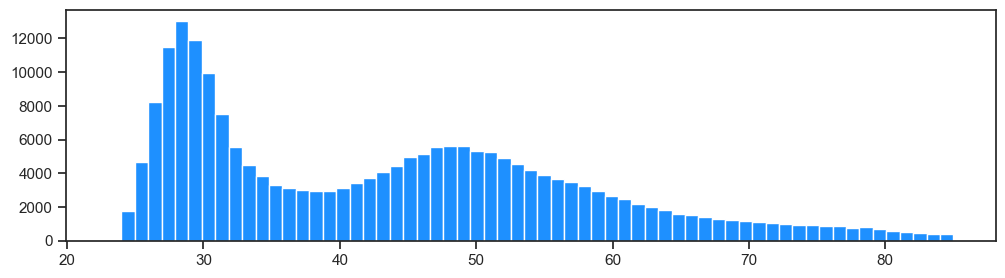

In [8]:
BINS = data[ estimated_column ].max() - data[ estimated_column ].min() + 1
data[ estimated_column ].to_pandas().hist(bins=BINS,grid=False,color='dodgerblue',figsize=(12,3)); plt.show()

In [9]:
data[estimated_column].to_pandas().value_counts().sort_values(ascending=False)[:10]

Age
28    13044
29    11924
27    11503
30     9938
26     8259
31     7537
48     5628
49     5627
47     5576
32     5560
Name: count, dtype: int64

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> STRATIFY & Classes

In [10]:
STRATIFY = pickle.load( open('STRATIFY','rb') )  # load
Classes  = pickle.load( open('Classes' ,'rb') )  # load
print( STRATIFY )
print( Classes  )

Tenthiles
['P025', 'P050', 'P075', 'P100']


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Percentiles

In [11]:
Percentiles = data[['Percentiles']]

pickle.dump( Percentiles , open('Percentiles' ,'wb') )  # save
Percentiles = pickle.load( open('Percentiles' ,'rb') )  # load

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Tenthiles

In [12]:
Tenthiles = data[['Tenthiles']]

pickle.dump( Tenthiles , open('Tenthiles' ,'wb') )  # save
Tenthiles = pickle.load( open('Tenthiles' ,'rb') )  # load

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Loading Dicts

In [13]:
# Binary
Binary_Dicts    = pickle.load( open('Binary_Dicts'   ,'rb') )  # load

# Ordinal
Ordinal_Dicts   = pickle.load( open('Ordinal_Dicts'  ,'rb') )  # load

# Nominal
Nominal_Cats    = pickle.load( open('Nominal_Cats'   ,'rb') )  # load
Nominal_SubCats = pickle.load( open('Nominal_SubCats','rb') )  # load
Nominal_Dicts   = pickle.load( open('Nominal_Dicts'  ,'rb') )  # load

In [14]:
# help
Binary_Dicts

Binary_Cat                      Dict
0          Gender  {0: 'Female', 1: 'Male'}
1  Credit_Product       {0: 'No', 1: 'Yes'}
2       Is_Active       {0: 'No', 1: 'Yes'}
3         Is_Lead       {0: 'No', 1: 'Yes'}

In [15]:
# help
Ordinal_Dicts

Ordinal_Cat                                               Dict
0        Month  {0: 'Jan', 1: 'Feb', 2: 'Mar', 3: 'Apr', 4: 'M...
1  Percentiles  {0: 'P001', 1: 'P002', 2: 'P005', 3: 'P010', 4...
2    Tenthiles       {0: 'P025', 1: 'P050', 2: 'P075', 3: 'P100'}

In [16]:
# help
print('Nominal_Cats:   ',Nominal_Cats)
print('Nominal_SubCats:',Nominal_SubCats)
Nominal_Dicts


Nominal_Cats:    ['Occupation', 'Channel_Code', 'Region_Code']
Nominal_SubCats: ['Occupation_P025', 'Occupation_P050', 'Occupation_P075', 'Occupation_P100', 'Channel_Code_P025', 'Channel_Code_P050', 'Channel_Code_P075', 'Channel_Code_P100', 'Region_Code_P025', 'Region_Code_P050', 'Region_Code_P075', 'Region_Code_P100']


NomCat_DF
Occupation          Occupation  Occupation_P025  Occupation_...
Channel_Code    Channel_Code  Channel_Code_P025  Channel_Cod...
Region_Code      Region_Code  Region_Code_P025  Region_Code_...

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Correcting Nominal_Cats
 - removing **estimated_column** from **Nominal_Cats**

In [17]:
try: 
    Nominal_Cats.remove(estimated_column)
except: 
    Nominal_Cats = Nominal_Cats

print( " estimated_column:  ", estimated_column )
print( " Nominal_Cats:    "  , Nominal_Cats     )

 estimated_column:   Age
 Nominal_Cats:     ['Occupation', 'Channel_Code', 'Region_Code']


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Converting Binary & Ordinal Features into numbers

In [18]:
# auto
data = data.to_pandas()

Bin_Cols = Binary_Dicts[ 'Binary_Cat' ].tolist()
Ord_Cols = Ordinal_Dicts['Ordinal_Cat'].tolist()

''' 
if estimated_column in Bin_Cols:
    Bin_Cols.remove(estimated_column)
elif estimated_column in Ord_Cols:
    Ord_Cols.remove(estimated_column)
''' 

i = 0
for c in Bin_Cols:
    if c in data.columns:
        Dict = Binary_Dicts.loc[i,'Dict']
        #print(Dict.keys())
        for key in Dict.keys():
            #print(key,Dict[key])
            data[c] = data[c].replace( Dict[key], key )  
    i = i + 1
    
i = 0
for c in Ord_Cols:
    if c in data.columns:
        Dict = Ordinal_Dicts.loc[i,'Dict']
        #print(Dict.keys())
        for key in Dict.keys():
            #print(key,Dict[key])
            data[c] = data[c].replace( Dict[key], key ) 
    i = i + 1
    
data = pl.from_pandas(  data )
data = Optimize_dtypes( data )
data.tail(30)

C:\Users\EZ-Tech\AppData\Local\Temp\ipykernel_10136\504753262.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[c] = data[c].replace( Dict[key], key )
C:\Users\EZ-Tech\AppData\Local\Temp\ipykernel_10136\504753262.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[c] = data[c].replace( Dict[key], key )


shape: (30, 25)
┌─────┬────────────────┬────────────────┬────────┬───┬────────────────┬────────────────┬───────────────┬───────────────┐
│ Age ┆ Avg_Account_Ba ┆ Credit_Product ┆ Gender ┆ … ┆ Region_Code_P0 ┆ Region_Code_P0 ┆ Region_Code_P ┆ Region_Code_P │
│ --- ┆ lance          ┆ ---            ┆ ---    ┆   ┆ 25             ┆ 50             ┆ 075           ┆ 100           │
│ i8  ┆ ---            ┆ i8             ┆ i8     ┆   ┆ ---            ┆ ---            ┆ ---           ┆ ---           │
│     ┆ i32            ┆                ┆        ┆   ┆ i8             ┆ i8             ┆ i8            ┆ i8            │
╞═════╪════════════════╪════════════════╪════════╪═══╪════════════════╪════════════════╪═══════════════╪═══════════════╡
│ 26  ┆ 381480         ┆ 1              ┆ 0      ┆ … ┆ 29             ┆ 29             ┆ 21            ┆ 19            │
│ 31  ┆ 790346         ┆ 0              ┆ 0      ┆ … ┆ 39             ┆ 30             ┆ 16            ┆ 13            │
│ 29  ┆ 420453         ┆ 0              ┆ 0      ┆ … ┆ 36             ┆ 32             ┆ 15            ┆ 15            │
│ 25  ┆ 533848         ┆ 1              ┆ 1      ┆ … ┆ 34             ┆ 23             ┆ 20            ┆ 20            │
│ 40  ┆ 2556888        ┆ 0              ┆ 1      ┆ … ┆ 10             ┆ 20             ┆ 34            ┆ 34            │
│ …   ┆ …              ┆ …              ┆ …      ┆ … ┆ …              ┆ …              ┆ …             ┆ …             │
│ 32  ┆ 1257943        ┆ 0              ┆ 0      ┆ … ┆ 9              ┆ 20             ┆ 34            ┆ 34            │
│ 44  ┆ 700634         ┆ 0              ┆ 1      ┆ … ┆ 19             ┆ 22             ┆ 27            ┆ 30            │
│ 54  ┆ 674593         ┆ 0              ┆ 1      ┆ … ┆ 9              ┆ 20             ┆ 34            ┆ 34            │
│ 48  ┆ 1149773        ┆ 0              ┆ 1      ┆ … ┆ 24             ┆ 32             ┆ 22            ┆ 20            │
│ 46  ┆ 243584         ┆ 0              ┆ 0      ┆ … ┆ 27             ┆ 22             ┆ 25            ┆ 24            │
└─────┴────────────────┴────────────────┴────────┴───┴────────────────┴────────────────┴───────────────┴───────────────┘

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Detaching Nominal_Cats

In [19]:
Non_Nominal_Cats = [x for x in data.columns if x not in Nominal_Cats ]

# to pd
Data_Nominal = pd.DataFrame( data[:,    Nominal_Cats].to_pandas() )
Data         = pd.DataFrame( data[:,Non_Nominal_Cats].to_pandas() )

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Functions

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Defining Genetic Algorithm Optimizer

In [20]:
''' 

# pip install sklearn-genetic-opt
from sklearn_genetic           import GAFeatureSelectionCV, GASearchCV
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar
from sklearn_genetic.space     import Categorical as GA_Categorical 
from sklearn_genetic.space     import Integer     as GA_Integer 
from sklearn_genetic.space     import Continuous  as GA_Continuous 
from sklearn_genetic.plots     import plot_fitness_evolution
from sklearn_genetic.plots     import plot_search_space

# defining G.A. Optimizer
def GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR,CV,Search_Space_Features,SCORING
             , Pop_Size,   Gens,   Tours,   Crossover,   Mutation
             , X_Train, y_Train, X_Valid, y_Valid ):
    
    callbacks = [LogbookSaver( checkpoint_path="./GA_logbook_DTree.pkl"),ProgressBar()]
    
    param_grid = {}
    for item in CATs:  param_grid[item[0]]=GA_Categorical(item[1])
    for item in TFs:   param_grid[item[0]]=GA_Categorical([True,False])
    for item in INTs:  param_grid[item[0]]=GA_Integer(item[1],item[2])
    for item in CONTs: param_grid[item[0]]=GA_Continuous(item[1],item[2],distribution=item[4])

    optimal_params = GASearchCV(
          estimator=ESTIMATOR, cv=CV, param_grid=param_grid, scoring=SCORING, population_size=Pop_Size
        , generations=Gens, tournament_size=Tours, elitism=True, keep_top_k=10, crossover_probability=Crossover
        , mutation_probability=Mutation, criteria="max", algorithm="eaMuCommaLambda", n_jobs=-1 ) 

    print('initiating ...')
    optimal_params.fit( X_Train, y_Train, callbacks = callbacks )

    accuracy = optimal_params.score( X_Valid, y_Valid )  
    print('\n\nBest Parameters:', optimal_params.best_params_)
    print('accuracy =', accuracy)
    
    plot_search_space( optimal_params, features=Search_Space_Features )
    plt.show()           
        
    Top_Params = optimal_params.logbook.chapters["parameters"]    
    return [ optimal_params.best_params_ , Top_Params ]
    
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Defining Processor

In [21]:
def PROCESS_REG( REG, X, y ):
    pred      = REG.predict( X )
    r2        = r2_score( y, pred )
    adj_r2    = 1 - ( ((1-r2)*(X.shape[0]-1)) / (X.shape[0]-X.shape[1]-1) )
    Residuals = y - pred
    dSq       = Residuals**2
    rmse      = ( sum(dSq)/len(dSq) )**0.5
    stat, p   = shapiro( Residuals )
    normality = p
    return [ r2, adj_r2, rmse, normality ]

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Defining BaseLine Plotter

In [22]:
def Plot_Single_Reg( BaseLine, REG_Name, X, y, est_col ): 
    
    BaseLine_Pred = BaseLine.predict( X )
    
    BaseLine_r2,  BaseLine_adj_r2,  BaseLine_rmse,  BaseLine_normality  =  PROCESS_REG( BaseLine, X, y )
    
    X_ax = range( len(y) )
    fig, ax = plt.subplots(figsize=(13,5))
    ax.plot( X_ax , BaseLine_Pred, ls='-', marker='o', color='cyan'       )
    ax.plot( X_ax , y            , ls='-', marker='o', color='dodgerblue' )
    ax.set_title(  REG_Name 
                + '\nr2 = '      +  str( np.round(BaseLine_r2,3)          )
                + '   ---   ' 
                + 'adj_r2 = '    +  str( np.round(BaseLine_adj_r2,3)      )
                + '   ---   ' 
                + 'rmse = '      +  str( int(np.round(BaseLine_rmse,-1))  ) 
                + '   ---   ' 
                + 'normality = ' +  str( np.round(100*BaseLine_normality,1) ) + ' (%)   ---   BaseLine '
                )
    ax.legend(['BaseLine','True'])   
    plt.savefig( est_col+'_'+str(np.round(BaseLine_rmse,2))+'_'+REG_Name+'_BaseLine.png'
               , dpi=120 )
    plt.show()

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Defining Comparison Plotter

In [23]:
def Plot_Dual_Reg( BaseLine, REG, REG_Name, X, y, est_col ):
    
    BaseLine_Pred = BaseLine.predict( X )
    REG_Pred      = REG.predict( X )
    
    
    BaseLine_r2,  BaseLine_adj_r2,  BaseLine_rmse,  BaseLine_normality  =  PROCESS_REG( BaseLine, X, y )
    REG_r2     ,  REG_adj_r2     ,  REG_rmse     ,  REG_normality       =  PROCESS_REG(   REG   , X, y )
    
    X_ax = range( len(y) )
    fig, ax = plt.subplots(figsize=(13,5))
    ax.plot( X_ax , y            , ls='-', marker='o', color='dodgerblue' )
    ax.plot( X_ax , BaseLine_Pred, ls='-', marker='o', color='cyan'       )
    ax.plot( X_ax , REG_Pred     , ls='-', marker='o', color='deeppink'   )
    
    ax.set_title( REG_Name    
                + '\nr2 = '      +  str( np.round(BaseLine_r2,3)     )
                + '   ---   ' 
                  'adj_r2 = '    +  str( np.round(BaseLine_adj_r2,3) )
                + '   ---   ' 
                + 'rmse = '      +  str( np.round(BaseLine_rmse,3)   ) 
                + '   ---   ' 
                + 'normality = ' +  str( np.round(100*BaseLine_normality,1) ) + ' (%)   ---   BaseLine '
        
                + '\nr2 = '      +  str( np.round(REG_r2,3)     )
                + '   ---   ' 
                + 'adj_r2 = '    +  str( np.round(REG_adj_r2,3) )
                + '   ---   ' 
                + 'rmse = '      +  str( np.round(REG_rmse,3)   ) 
                + '   ---   ' 
                + 'normality = ' +  str( np.round(100*REG_normality,1) )      + ' (%)   ---   Optimized' 
                )
    
    ax.legend(['True','BaseLine','Optimized'])   
    plt.savefig( est_col+'_'+str(np.round(REG_rmse,2))+'_'+REG_Name+'.png'
               , dpi=120 )
    plt.show()

#####     

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> X & y

In [24]:
X = Data.drop([estimated_column], axis=1).copy()
#X = pd.get_dummies( X ).replace(False,0).replace(True,1)
y = Data[estimated_column].copy() 

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Scaling

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scaling
Scaler  = MinMaxScaler().fit(X)
Columns = X.columns
X = Scaler.transform(X)
X = pd.DataFrame(X,columns=Columns)
X.index = range(X.shape[0])
X.tail()

Avg_Account_Balance  Credit_Product  Gender  Is_Active  Is_Lead  \
216182             0.368056             0.0     0.0        0.0      1.0   
216183             0.202255             0.0     1.0        1.0      0.0   
216184             0.194508             0.0     1.0        0.0      1.0   
216185             0.335875             0.0     1.0        1.0      1.0   
216186             0.066282             0.0     0.0        1.0      0.0   

           Month  Percentiles  Tenthiles   Vintage  Occupation_P025  \
216182  0.909091         0.16   0.333333  0.046875         1.000000   
216183  0.818182         0.40   0.666667  0.289062         0.092593   
216184  0.909091         0.60   1.000000  0.664062         0.092593   
216185  1.000000         0.48   0.666667  0.437500         1.000000   
216186  0.181818         0.44   0.666667  0.531250         0.092593   

        Occupation_P050  Occupation_P075  Occupation_P100  Channel_Code_P025  \
216182         1.000000         0.000000         0.038462           0.000000   
216183         0.428571         0.534884         0.442308           0.019608   
216184         0.428571         0.534884         0.442308           0.000000   
216185         1.000000         0.011628         0.038462           0.000000   
216186         0.428571         0.534884         0.442308           0.000000   

        Channel_Code_P050  Channel_Code_P075  Channel_Code_P100  \
216182           0.393939              1.000           0.622222   
216183           0.030303              0.825           1.000000   
216184           0.393939              1.000           0.622222   
216185           0.393939              1.000           0.622222   
216186           0.393939              1.000           0.622222   

        Region_Code_P025  Region_Code_P050  Region_Code_P075  Region_Code_P100  
216182          0.000000          0.000000          1.000000          1.000000  
216183          0.277778          0.095238          0.708333          0.826087  
216184          0.000000          0.000000          1.000000          1.000000  
216185          0.416667          0.571429          0.500000          0.391304  
216186          0.500000          0.095238          0.625000          0.565217

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Feature Selection - Heat-Map of Correlations (Prearson's r)
 - As the data is cleaned, **Pearson's r** correlation method can be used.

In [26]:
Corr = pd.concat([X,y],axis=1).corr('pearson') 
Corr.sort_values([estimated_column],ascending=[False],inplace=True)
Corr = Corr.T
Corr.sort_values([estimated_column],ascending=[False],inplace=True)
                  
pickle.dump( Corr,  open('Feature_Selection_Corr','wb') )  # save
Corr = pickle.load( open('Feature_Selection_Corr','rb') )  # load 

In [27]:
''' 
n = max( int(Corr.shape[0]), 13 )
fig,ax = plt.subplots(figsize=(n,n))
sns_plot = sns.heatmap( Corr, mask=np.zeros_like(Corr,dtype=bool), 
                        cmap='coolwarm',
                        square=True, ax=ax, annot=True, center=0.00 )
plt.savefig( 'Pearsons_r_Heat_Map.png', dpi=360 )
plt.savefig( 'Pearsons_r_Heat_Map.pdf', dpi=360 )
plt.show()
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Corr of Estimated Column

In [28]:
''' 
CorrEstCol = Corr.loc[ :, [estimated_column] ]
CorrEstCol.columns = ["Pearson's r"]

pickle.dump( CorrEstCol,  open('Feature_Selection_CorrEstCol','wb') )  # save
CorrEstCol = pickle.load( open('Feature_Selection_CorrEstCol','rb') )  # load 

# HeatMap
n = min( int(CorrEstCol.shape[0]), 13 )
fig,ax = plt.subplots(figsize=(n,n))
sns_plot = sns.heatmap( CorrEstCol, mask=np.zeros_like(CorrEstCol,dtype=bool), 
                        cmap='coolwarm',
                        square=True, ax=ax, annot=True, center=0.00 )
plt.savefig( 'Pearsons_r_Heat_Map_EstCol.png', dpi=360 )
plt.savefig( 'Pearsons_r_Heat_Map_EstCol.pdf', dpi=360 )
plt.show()
''' 
pass

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> Dropping Highly Correlated Features

In [29]:
Threshhold = .95
L = []
for i in Corr.index:
    for j in Corr.index:
        if i != j:
            if abs(Corr.loc[i,j]) >= Threshhold:
                L.append([  i, abs( Corr.loc[i,estimated_column] ),
                            j, abs( Corr.loc[j,estimated_column] ),
                               abs( Corr.loc[i,j]                ) 
                         ])
                
L = pd.DataFrame(L)
L.columns = ['row', 'row-'+estimated_column, 'col', 'col-'+estimated_column, 'row-col']
L

row   row-Age                col   col-Age   row-col
0                 Age  1.000000        Percentiles  0.996749  0.996749
1         Percentiles  0.996749                Age  1.000000  0.996749
2   Channel_Code_P100  0.681162  Channel_Code_P050  0.657242  0.984550
3   Channel_Code_P075  0.662186  Channel_Code_P025  0.681133  0.990215
4    Region_Code_P100  0.286698   Region_Code_P075  0.285713  0.979311
5    Region_Code_P100  0.286698   Region_Code_P025  0.282668  0.953347
6    Region_Code_P075  0.285713   Region_Code_P100  0.286698  0.979311
7    Region_Code_P075  0.285713   Region_Code_P025  0.282668  0.963738
8    Region_Code_P025  0.282668   Region_Code_P100  0.286698  0.953347
9    Region_Code_P025  0.282668   Region_Code_P075  0.285713  0.963738
10  Channel_Code_P050  0.657242  Channel_Code_P100  0.681162  0.984550
11  Channel_Code_P025  0.681133  Channel_Code_P075  0.662186  0.990215

In [30]:
D = []
for i in L.index:
    if L.loc[i,'row-'+estimated_column] < L.loc[i,'col-'+estimated_column] :
        D.append( L.loc[i,'row'] )
    else :
        D.append( L.loc[i,'col'] )
        
Drop_List = list(set(D))

try: 
    Drop_List.remove(estimated_column)
    print( '\nestimated_column ("'+ estimated_column +'") was removed from Drop_List. input its counterpart manually.' )
except:
    pass

try: 
    Drop_List.remove('Percentiles')
    print( '\n"Percentiles" was removed from Drop_List. input its counterpart manually.' )
except:
    pass

try: 
    Drop_List.remove('Tenthiles')
    print( '\n "Tenthiles"  was removed from Drop_List. input its counterpart manually.' )
except:
    pass

Drop_List.sort()
Drop_List


"Percentiles" was removed from Drop_List. input its counterpart manually.


['Channel_Code_P050',
 'Channel_Code_P075',
 'Region_Code_P025',
 'Region_Code_P075']

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Drop List

In [31]:
#Drop_List = [ 'origin_P99' ]

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Simplifying X

In [32]:
Simplified_FTs = X.columns.tolist().copy()

for i in Drop_List:
    if i in Simplified_FTs: 
        Simplified_FTs.remove( i )

X = X[ Simplified_FTs ]
print(X.shape)
X.head()

(216187, 17)


Avg_Account_Balance  Credit_Product  Gender  Is_Active  Is_Lead     Month  \
0             0.174088             0.0     0.0        0.0      0.0  0.000000   
1             0.146242             1.0     0.0        1.0      1.0  0.090909   
2             0.211727             0.0     1.0        1.0      0.0  0.727273   
3             0.148442             0.0     1.0        0.0      1.0  0.000000   
4             0.339317             0.0     1.0        0.0      1.0  0.909091   

   Percentiles  Tenthiles   Vintage  Occupation_P025  Occupation_P050  \
0         0.18   0.333333  0.187500         0.092593         0.428571   
1         0.50   0.666667  0.710938         0.314815         0.178571   
2         0.42   0.666667  0.343750         0.092593         0.428571   
3         0.58   0.666667  0.515625         0.092593         0.428571   
4         0.26   0.333333  0.156250         1.000000         1.000000   

   Occupation_P075  Occupation_P100  Channel_Code_P025  Channel_Code_P100  \
0         0.534884         0.442308           1.000000           0.022222   
1         0.127907         1.000000           0.000000           0.622222   
2         0.534884         0.442308           0.019608           1.000000   
3         0.534884         0.442308           0.000000           0.622222   
4         0.000000         0.038462           1.000000           0.000000   

   Region_Code_P050  Region_Code_P100  
0          0.476190          0.391304  
1          0.571429          0.391304  
2          0.523810          0.130435  
3          0.047619          0.956522  
4          0.523810          0.130435

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Ataching Nominal_Cats

In [33]:
X = pd.concat([Data_Nominal,X],axis=1);     X.index=range(X.shape[0])
X.tail()

Occupation Channel_Code Region_Code  Avg_Account_Balance  \
216182       Salaried           X2       RG268             0.368056   
216183  Self_Employed           X3       RG276             0.202255   
216184  Self_Employed           X2       RG268             0.194508   
216185       Salaried           X2       RG277             0.335875   
216186  Self_Employed           X2       RG280             0.066282   

        Credit_Product  Gender  Is_Active  Is_Lead     Month  Percentiles  \
216182             0.0     0.0        0.0      1.0  0.909091         0.16   
216183             0.0     1.0        1.0      0.0  0.818182         0.40   
216184             0.0     1.0        0.0      1.0  0.909091         0.60   
216185             0.0     1.0        1.0      1.0  1.000000         0.48   
216186             0.0     0.0        1.0      0.0  0.181818         0.44   

        Tenthiles   Vintage  Occupation_P025  Occupation_P050  \
216182   0.333333  0.046875         1.000000         1.000000   
216183   0.666667  0.289062         0.092593         0.428571   
216184   1.000000  0.664062         0.092593         0.428571   
216185   0.666667  0.437500         1.000000         1.000000   
216186   0.666667  0.531250         0.092593         0.428571   

        Occupation_P075  Occupation_P100  Channel_Code_P025  \
216182         0.000000         0.038462           0.000000   
216183         0.534884         0.442308           0.019608   
216184         0.534884         0.442308           0.000000   
216185         0.011628         0.038462           0.000000   
216186         0.534884         0.442308           0.000000   

        Channel_Code_P100  Region_Code_P050  Region_Code_P100  
216182           0.622222          0.000000          1.000000  
216183           1.000000          0.095238          0.826087  
216184           0.622222          0.000000          1.000000  
216185           0.622222          0.571429          0.391304  
216186           0.622222          0.095238          0.565217

#####     

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Splitting into Train, Valid

In [34]:
# help
print( X.columns.to_list() )

['Occupation', 'Channel_Code', 'Region_Code', 'Avg_Account_Balance', 'Credit_Product', 'Gender', 'Is_Active', 'Is_Lead', 'Month', 'Percentiles', 'Tenthiles', 'Vintage', 'Occupation_P025', 'Occupation_P050', 'Occupation_P075', 'Occupation_P100', 'Channel_Code_P025', 'Channel_Code_P100', 'Region_Code_P050', 'Region_Code_P100']


In [35]:
# input
sclrs = [ 'Avg_Account_Balance', 'Credit_Product', 'Gender', 'Is_Active', 'Is_Lead', 'Month', 'Vintage' ]

In [36]:
cats  = [ x for x in X.columns if X[x].dtype=='object' ]
new_cats = [ ]
df                   = X.copy()
df[estimated_column] = y.copy()
DF = df[ cats ].copy()
for sclr in sclrs:
    A = []
    P = []
    if sclr==estimated_column:
        for i in np.arange(10,101,10).tolist():
            p = np.percentile(df[sclr],i)
            P.append(p)
        for val in df[sclr]:
            i=0
            while val>P[i] and i<len(P)-1:
                i=i+1
            A.append(sclr+'_P'+str(i))
    else:
        for i in np.arange(20,101,20).tolist():
            p = np.percentile(df[sclr],i)
            P.append(p)
        for val in df[sclr]:
            i=0
            while val>P[i] and i<len(P)-1:
                i=i+1
            A.append(sclr+'_P'+str(i))
    new_cat = sclr+'_Percentiles'
    new_cats.append( new_cat )
    DF[new_cat] = A

df['I']=''
for c in cats+new_cats:
    df['I'] = DF[c] +'_'+ df['I']
del DF
len( df['I'].unique() )

96918

In [37]:
new = pd.DataFrame( df['I'].value_counts() )
new['Uniq'] = new.index
new.index = range(new.shape[0])
for i in new.index:
    if new.loc[i,'count'] < 5:
        new.loc[i,'Uniq'] = None
new = new['Uniq'].dropna().tolist()
print(len(new))

9473


In [38]:
A = []
for val in df['I']:
    if val in new:
        A.append(val)
    else:
        A.append('Other')
df['I'] = A
df

Occupation Channel_Code Region_Code  Avg_Account_Balance  \
0       Self_Employed           X1       RG282             0.174088   
1               Other           X2       RG277             0.146242   
2       Self_Employed           X3       RG261             0.211727   
3       Self_Employed           X2       RG284             0.148442   
4            Salaried           X1       RG261             0.339317   
...               ...          ...         ...                  ...   
216182       Salaried           X2       RG268             0.368056   
216183  Self_Employed           X3       RG276             0.202255   
216184  Self_Employed           X2       RG268             0.194508   
216185       Salaried           X2       RG277             0.335875   
216186  Self_Employed           X2       RG280             0.066282   

        Credit_Product  Gender  Is_Active  Is_Lead     Month  Percentiles  \
0                  0.0     0.0        0.0      0.0  0.000000         0.18   
1                  1.0     0.0        1.0      1.0  0.090909         0.50   
2                  0.0     1.0        1.0      0.0  0.727273         0.42   
3                  0.0     1.0        0.0      1.0  0.000000         0.58   
4                  0.0     1.0        0.0      1.0  0.909091         0.26   
...                ...     ...        ...      ...       ...          ...   
216182             0.0     0.0        0.0      1.0  0.909091         0.16   
216183             0.0     1.0        1.0      0.0  0.818182         0.40   
216184             0.0     1.0        0.0      1.0  0.909091         0.60   
216185             0.0     1.0        1.0      1.0  1.000000         0.48   
216186             0.0     0.0        1.0      0.0  0.181818         0.44   

        Tenthiles   Vintage  Occupation_P025  Occupation_P050  \
0        0.333333  0.187500         0.092593         0.428571   
1        0.666667  0.710938         0.314815         0.178571   
2        0.666667  0.343750         0.092593         0.428571   
3        0.666667  0.515625         0.092593         0.428571   
4        0.333333  0.156250         1.000000         1.000000   
...           ...       ...              ...              ...   
216182   0.333333  0.046875         1.000000         1.000000   
216183   0.666667  0.289062         0.092593         0.428571   
216184   1.000000  0.664062         0.092593         0.428571   
216185   0.666667  0.437500         1.000000         1.000000   
216186   0.666667  0.531250         0.092593         0.428571   

        Occupation_P075  Occupation_P100  Channel_Code_P025  \
0              0.534884         0.442308           1.000000   
1              0.127907         1.000000           0.000000   
2              0.534884         0.442308           0.019608   
3              0.534884         0.442308           0.000000   
4              0.000000         0.038462           1.000000   
...                 ...              ...                ...   
216182         0.000000         0.038462           0.000000   
216183         0.534884         0.442308           0.019608   
216184         0.534884         0.442308           0.000000   
216185         0.011628         0.038462           0.000000   
216186         0.534884         0.442308           0.000000   

        Channel_Code_P100  Region_Code_P050  Region_Code_P100  Age  \
0                0.022222          0.476190          0.391304   33   
1                0.622222          0.571429          0.391304   49   
2                1.000000          0.523810          0.130435   45   
3                0.622222          0.047619          0.956522   53   
4                0.000000          0.523810          0.130435   37   
...                   ...               ...               ...  ...   
216182           0.622222          0.000000          1.000000   32   
216183           1.000000          0.095238          0.826087   44   
216184           0.622222          0.000000          1.000000   5

In [39]:
print( df.shape )

(216187, 22)


In [40]:
#Sample = df.groupby('I', group_keys=False).apply(lambda x: x.sample(n=5))
#Sample.index = range(Sample.shape[0])
#Sample

In [41]:
#X = Sample.drop( estimated_column, axis=1 )
#y = Sample[ estimated_column ]

In [42]:
# input
#Tiles = 'I'   # 'Percentiles' 'Tenthiles' 

In [43]:
X = df.drop( estimated_column, axis=1 )
y = df[ estimated_column ]

# (input)
X_Train, X_Valid, y_Train, y_Valid  =  train_test_split(        
          X, y
        , random_state  =  RANDOM_STATE
        , test_size     =  2*(1+len(new))/X.shape[0]
        , shuffle       =  True 
        , stratify      =  X[ 'I' ]
        )

# (auto)
X_Train.index=range(X_Train.shape[0]); X_Train_Nominal=X_Train[Nominal_Cats]; X_Train=X_Train.drop(Nominal_Cats+[    'Percentiles','Tenthiles'],axis=1)
X_Valid.index=range(X_Valid.shape[0]); X_Valid_Nominal=X_Valid[Nominal_Cats]; X_Valid=X_Valid.drop(Nominal_Cats+['I','Percentiles','Tenthiles'],axis=1)
 
y_Train.index=range(y_Train.shape[0])
y_Valid.index=range(y_Valid.shape[0])
 
df_Valid = pd.concat([ X_Valid, y_Valid ], axis=1 )
df_Valid.sort_values([estimated_column],ascending=[True],inplace=True)
y_Valid  = df_Valid[estimated_column]
X_Valid  = df_Valid
X_Valid.drop([estimated_column],axis=1,inplace=True)

print(X_Train.shape)

(197239, 16)


#####   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Initiating

In [44]:
# auto
Selected_Features = X_Valid.columns.tolist().copy()

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> Iterate

In [45]:
# (input)
n_iter = 10

# (auto)
df_imp_fts = pd.DataFrame( index=Selected_Features )

for rs in range( n_iter ):
    
    _, X_Sample, _, y_Sample = train_test_split(        
          X_Train, y_Train
        , random_state  =  rs
        , test_size     =  0.20  
        , shuffle       =  True 
        , stratify      =  X_Train[ 'I' ]
        )

    X_Sample.index=range(X_Sample.shape[0]); X_Sample=X_Sample.drop(['I'],axis=1) 
    y_Sample.index=range(y_Sample.shape[0])
        
    RF_BaseLine = RandomForestRegressor(
        n_estimators=min( 5, len(Selected_Features) ), random_state=RANDOM_STATE, 
        warm_start=False, bootstrap=True, max_depth=None, max_leaf_nodes=None, 
        min_samples_leaf=1, min_samples_split=2, n_jobs=-1, verbose=0
                                       ).fit( X_Sample[Selected_Features], y_Sample )
    
    df_imp_fts[str(rs)] = pd.DataFrame( RF_BaseLine.feature_importances_, index=Selected_Features, columns=[str(rs)] )
    
    print( 'finished iter '+str(rs+1)+' of '+str(n_iter) )


df_imp_fts = pd.DataFrame( df_imp_fts.T.sum() / df_imp_fts.T.sum().sum() 
                         , columns=['FT IMP'] 
                         ).sort_values(['FT IMP'],ascending=False)
print('Done!')


S=[]
for i in df_imp_fts.index:
    try:
        S.append( S[-1] + df_imp_fts.loc[i,'FT IMP'] )
    except:
        S.append(         df_imp_fts.loc[i,'FT IMP'] )
df_imp_fts[ 'SUM' ] = S
df_imp_fts

finished iter 1 of 10
finished iter 2 of 10
finished iter 3 of 10
finished iter 4 of 10
finished iter 5 of 10
finished iter 6 of 10
finished iter 7 of 10
finished iter 8 of 10
finished iter 9 of 10
finished iter 10 of 10
Done!


FT IMP       SUM
Vintage              0.514830  0.514830
Avg_Account_Balance  0.102755  0.617585
Occupation_P100      0.099936  0.717521
Channel_Code_P025    0.082515  0.800036
Channel_Code_P100    0.048337  0.848374
Month                0.041228  0.889602
Region_Code_P100     0.024883  0.914484
Region_Code_P050     0.022692  0.937176
Occupation_P075      0.011221  0.948397
Gender               0.009971  0.958368
Is_Lead              0.009747  0.968115
Is_Active            0.009320  0.977435
Credit_Product       0.008653  0.986088
Occupation_P050      0.007298  0.993386
Occupation_P025      0.006614  1.000000

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:deeppink;"> Selected Features by Percent

In [46]:
# input
percent = .9000001

# auto
Selected_Features = df_imp_fts.loc[ df_imp_fts['SUM']< percent ].index.tolist()
Last_Feature      = df_imp_fts.loc[ df_imp_fts['SUM']>=percent ].index.tolist()[0]

Selected_Features.append( Last_Feature )
df_imp_fts = df_imp_fts.loc[ Selected_Features, : ]

pickle.dump( df_imp_fts,  open('df_imp_fts','wb') )  # save
df_imp_fts = pickle.load( open('df_imp_fts','rb') )  # load

df_imp_fts

FT IMP       SUM
Vintage              0.514830  0.514830
Avg_Account_Balance  0.102755  0.617585
Occupation_P100      0.099936  0.717521
Channel_Code_P025    0.082515  0.800036
Channel_Code_P100    0.048337  0.848374
Month                0.041228  0.889602
Region_Code_P100     0.024883  0.914484

In [47]:
print( df.shape, X_Train.shape )

(216187, 22) (197239, 16)


In [48]:
data.shape

(216187, 25)

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> RF_BaseLine .......... (Validation Data)

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 18948.
  res = hypotest_fun_out(*samples, **kwds)


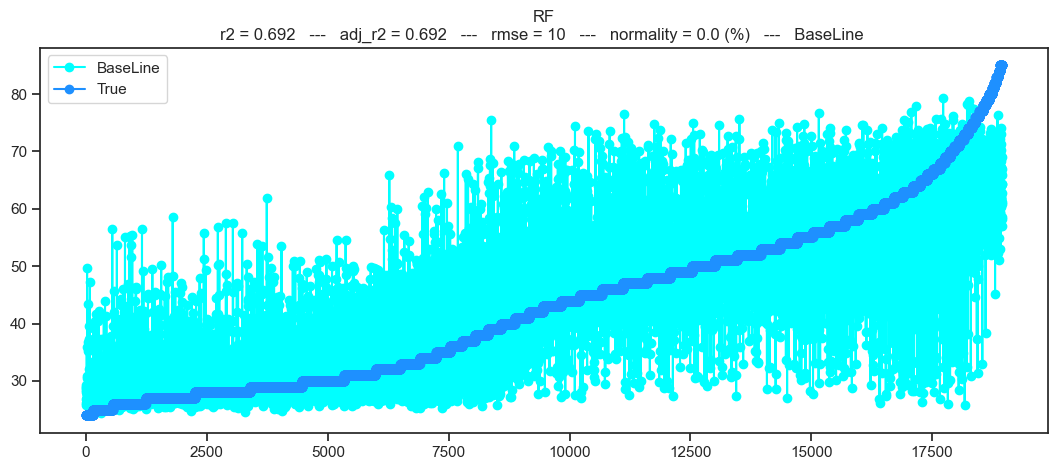

In [49]:
try:
    ;
    #X_Train=X_Train.drop(['I'],axis=1)
except:
    ;
RF_BaseLine = RandomForestRegressor(

    n_estimators=len( Selected_Features )*5, random_state=RANDOM_STATE, 
    warm_start=False, bootstrap=True, max_depth=None, max_leaf_nodes=None, 
    min_samples_leaf=1, min_samples_split=2, n_jobs=-1, verbose=0

                                   ).fit( X_Train[Selected_Features], y_Train )

Plot_Single_Reg( RF_BaseLine, "RF", X_Valid[Selected_Features], y_Valid, estimated_column )

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> Save

In [50]:
# help
print( Selected_Features )

['Vintage', 'Avg_Account_Balance', 'Occupation_P100', 'Channel_Code_P025', 'Channel_Code_P100', 'Month', 'Region_Code_P100']


In [51]:
# input 
#Selected_Features = [  'Vintage', 'Avg_Account_Balance', 'Occupation_P100', 'Channel_Code_P100', 'Channel_Code_P025', 'Region_Code', 'Month', 'Is_Lead' ]

# auto
pickle.dump( Selected_Features,  open('Selected_Features','wb') )  # save
Selected_Features = pickle.load( open('Selected_Features','rb') )  # load
print( Selected_Features )

['Vintage', 'Avg_Account_Balance', 'Occupation_P100', 'Channel_Code_P025', 'Channel_Code_P100', 'Month', 'Region_Code_P100']


#####   
<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:deeppink;"> Re-Iterate

#####   

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> PCA for EDA

In [52]:
from sklearn.decomposition import PCA

X_PCA       = df[Selected_Features]

X_PCA       = StandardScaler().fit_transform( X_PCA )
X_PCA       = pd.DataFrame( X_PCA, columns=Selected_Features )
X_PCA.index = range(X_PCA.shape[0])

pca   = PCA().fit( X_PCA )  
X_PCA = pca.transform( X_PCA )

pickle.dump( pca,  open('PCA_EDA','wb') )  # save
pca = pickle.load( open('PCA_EDA','rb') )  # load

X_PCA = np.column_stack((  
    X_PCA[:,0], 
    X_PCA[:,1], 
    X_PCA[:,2]  
    ))
X_PCA = pd.DataFrame( X_PCA, columns=[ 'pca1', 'pca2', 'pca3' ] ) 

data_raw = pickle.load( open('Data_Clean','rb') )  # load 
data_raw = Optimize_dtypes(data_raw)
data_raw = data_raw.to_pandas().dropna( subset=[estimated_column] ) 
if sum( data_raw.duplicated() ) > 0:
    data_raw = data_raw.drop_duplicates()
    data_raw.index = range( data_raw.shape[0] ) 

Data_PCA = pd.concat( 
    [ X_PCA, data_raw ],
    axis = 1
    )
Data_PCA = Data_PCA.drop( Nominal_SubCats, axis=1 )
Data_PCA = pl.from_pandas(  Data_PCA )
#Data_PCA = Optimize_dtypes( Data_PCA )


pickle.dump( Data_PCA,  open('Data_PCA','wb') )  # save
Data_PCA = pickle.load( open('Data_PCA','rb') )  # load
Data_PCA.to_pandas().to_csv('Data_PCA.csv')   # save (use in Tableau)

Data_PCA.tail()

shape: (5, 16)
┌──────────┬───────────┬───────────┬─────┬───┬─────────┬────────────┬──────────────┬─────────────┐
│ pca1     ┆ pca2      ┆ pca3      ┆ Age ┆ … ┆ Vintage ┆ Occupation ┆ Channel_Code ┆ Region_Code │
│ ---      ┆ ---       ┆ ---       ┆ --- ┆   ┆ ---     ┆ ---        ┆ ---          ┆ ---         │
│ f64      ┆ f64       ┆ f64       ┆ i8  ┆   ┆ i16     ┆ str        ┆ str          ┆ str         │
╞══════════╪═══════════╪═══════════╪═════╪═══╪═════════╪════════════╪══════════════╪═════════════╡
│ 0.233268 ┆ 0.9312    ┆ 1.293132  ┆ 67  ┆ … ┆ 122     ┆ Other      ┆ X3           ┆ RG251       │
│ 1.166184 ┆ -0.473296 ┆ 1.0087    ┆ 63  ┆ … ┆ 63      ┆ Other      ┆ X3           ┆ RG276       │
│ 1.538023 ┆ -0.122014 ┆ 1.310493  ┆ 62  ┆ … ┆ 67      ┆ Other      ┆ X3           ┆ RG283       │
│ 0.373712 ┆ -0.335307 ┆ 1.580605  ┆ 85  ┆ … ┆ 79      ┆ Other      ┆ X3           ┆ RG277       │
│ 0.771606 ┆ -1.338883 ┆ -1.016564 ┆ 65  ┆ … ┆ 87      ┆ Other      ┆ X2           ┆ RG283       │
└──────────┴───────────┴───────────┴─────┴───┴─────────┴────────────┴──────────────┴─────────────┘

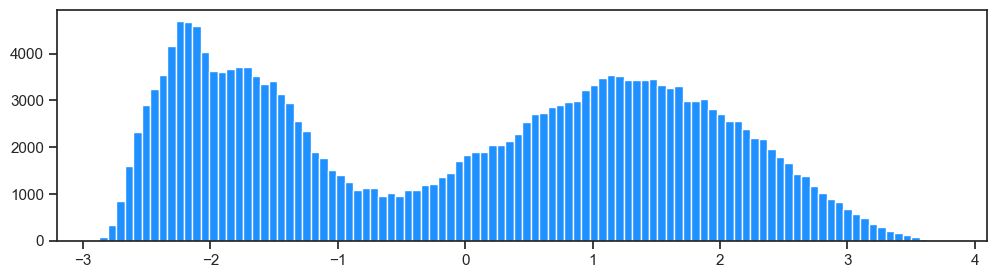

In [53]:
Data_PCA['pca1'].to_pandas().hist(bins=100,grid=False,color='dodgerblue',figsize=(12,3)); plt.show()

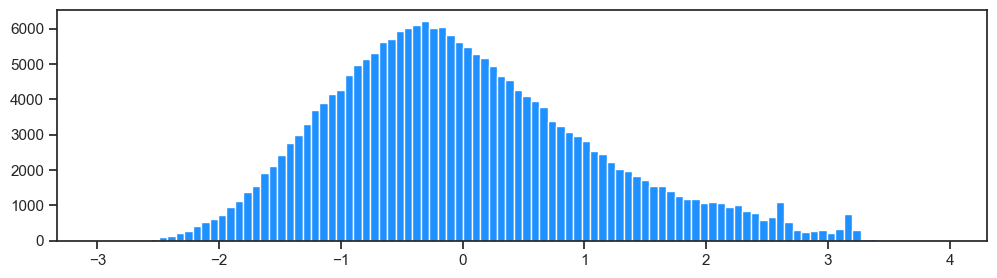

In [54]:
Data_PCA['pca2'].to_pandas().hist(bins=100,grid=False,color='dodgerblue',figsize=(12,3)); plt.show()

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Selected_Features

In [55]:
Selected_Nominal_SubCats = [x for x in Selected_Features if x in Nominal_SubCats ]

pickle.dump( Selected_Nominal_SubCats , open('Selected_Nominal_SubCats' ,'wb') )  # save
Selected_Nominal_SubCats = pickle.load( open('Selected_Nominal_SubCats' ,'rb') )  # load
Selected_Nominal_SubCats

['Occupation_P100',
 'Channel_Code_P025',
 'Channel_Code_P100',
 'Region_Code_P100']

In [56]:
Selected_Nominal_Cats = [ ]

for NomCat in Nominal_Dicts.index:
    NomCat_Counter = 0
    SubCats = Nominal_Dicts.loc[NomCat,'NomCat_DF'].columns[1:].tolist()
    #print(NomCat,SubCats)
    for SubCat in SubCats:
        if SubCat in Selected_Nominal_SubCats:
            NomCat_Counter = NomCat_Counter+1
    if NomCat_Counter>0:
        Selected_Nominal_Cats.append(NomCat) 


pickle.dump( Selected_Nominal_Cats , open('Selected_Nominal_Cats' ,'wb') )  # save
Selected_Nominal_Cats = pickle.load( open('Selected_Nominal_Cats' ,'rb') )  # load
Selected_Nominal_Cats

['Occupation', 'Channel_Code', 'Region_Code']

In [57]:
Selected_Features = list(set( Selected_Nominal_Cats + Selected_Features ))
Selected_Features.sort()

pickle.dump( Selected_Features , open('Selected_Features' ,'wb') )  # save
Selected_Features = pickle.load( open('Selected_Features' ,'rb') )  # load
Selected_Features

['Avg_Account_Balance',
 'Channel_Code',
 'Channel_Code_P025',
 'Channel_Code_P100',
 'Month',
 'Occupation',
 'Occupation_P100',
 'Region_Code',
 'Region_Code_P100',
 'Vintage']

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Data FeatureSelected

In [58]:
data = data[Selected_Features+[estimated_column]]
data.tail(3)

shape: (3, 11)
┌─────────────────┬──────────────┬─────────────────┬────────────────┬───┬─────────────┬────────────────┬─────────┬─────┐
│ Avg_Account_Bal ┆ Channel_Code ┆ Channel_Code_P0 ┆ Channel_Code_P ┆ … ┆ Region_Code ┆ Region_Code_P1 ┆ Vintage ┆ Age │
│ ance            ┆ ---          ┆ 25              ┆ 100            ┆   ┆ ---         ┆ 00             ┆ ---     ┆ --- │
│ ---             ┆ str          ┆ ---             ┆ ---            ┆   ┆ str         ┆ ---            ┆ i16     ┆ i8  │
│ i32             ┆              ┆ i8              ┆ i8             ┆   ┆             ┆ i8             ┆         ┆     │
╞═════════════════╪══════════════╪═════════════════╪════════════════╪═══╪═════════════╪════════════════╪═════════╪═════╡
│ 674593          ┆ X2           ┆ 1               ┆ 32             ┆ … ┆ RG268       ┆ 34             ┆ 92      ┆ 54  │
│ 1149773         ┆ X2           ┆ 1               ┆ 32             ┆ … ┆ RG277       ┆ 20             ┆ 63      ┆ 48  │
│ 243584          ┆ X2           ┆ 1               ┆ 32             ┆ … ┆ RG280       ┆ 24             ┆ 75      ┆ 46  │
└─────────────────┴──────────────┴─────────────────┴────────────────┴───┴─────────────┴────────────────┴─────────┴─────┘

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Decoding

In [59]:
Data_Decoded = data.to_pandas()

# Decoding Binary
i = 0
for item in Binary_Dicts['Binary_Cat']:
    if item in Data_Decoded.columns:
        #Data_Decoded[item] = Data_Decoded[item].astype(float)
        Data_Decoded[item] = np.round( Data_Decoded[item].astype(float), 0 ) 
        Data_Decoded[item] = Data_Decoded[item].astype(int)
        D = Binary_Dicts.loc[i,'Dict']
        for key in D.keys(): 
            Data_Decoded[item] = Data_Decoded[item].replace(key,D[key]) 
    i = i+1


# Decoding Ordinal
i = 0
for item in Ordinal_Dicts['Ordinal_Cat']:
    if item in Data_Decoded.columns: 
        #Data_Decoded[item] = Data_Decoded[item].astype(float)
        Data_Decoded[item] = np.round( Data_Decoded[item].astype(float), 0 ) 
        Data_Decoded[item] = Data_Decoded[item].astype(int)
        D = Ordinal_Dicts.loc[i,'Dict'] 
        for key in D.keys(): 
            Data_Decoded[item] = Data_Decoded[item].replace(key,D[key])
    i = i+1


Data_Decoded.tail(3)

Avg_Account_Balance Channel_Code  Channel_Code_P025  \
216184               674593           X2                  1   
216185              1149773           X2                  1   
216186               243584           X2                  1   

        Channel_Code_P100 Month     Occupation  Occupation_P100 Region_Code  \
216184                 32   Nov  Self_Employed               23       RG268   
216185                 32   Dec       Salaried                2       RG277   
216186                 32   Mar  Self_Employed               23       RG280   

        Region_Code_P100  Vintage  Age  
216184                34       92   54  
216185                20       63   48  
216186                24       75   46

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Assigning

In [60]:
Data_FeatureSelected = pl.from_pandas( Data_Decoded )

pickle.dump( Data_FeatureSelected,  open('Data_FeatureSelected','wb') )  # save
Data_FeatureSelected = pickle.load( open('Data_FeatureSelected','rb') )  # load
Data_FeatureSelected.tail(3)

shape: (3, 11)
┌─────────────────┬──────────────┬─────────────────┬────────────────┬───┬─────────────┬────────────────┬─────────┬─────┐
│ Avg_Account_Bal ┆ Channel_Code ┆ Channel_Code_P0 ┆ Channel_Code_P ┆ … ┆ Region_Code ┆ Region_Code_P1 ┆ Vintage ┆ Age │
│ ance            ┆ ---          ┆ 25              ┆ 100            ┆   ┆ ---         ┆ 00             ┆ ---     ┆ --- │
│ ---             ┆ str          ┆ ---             ┆ ---            ┆   ┆ str         ┆ ---            ┆ i16     ┆ i8  │
│ i32             ┆              ┆ i8              ┆ i8             ┆   ┆             ┆ i8             ┆         ┆     │
╞═════════════════╪══════════════╪═════════════════╪════════════════╪═══╪═════════════╪════════════════╪═════════╪═════╡
│ 674593          ┆ X2           ┆ 1               ┆ 32             ┆ … ┆ RG268       ┆ 34             ┆ 92      ┆ 54  │
│ 1149773         ┆ X2           ┆ 1               ┆ 32             ┆ … ┆ RG277       ┆ 20             ┆ 63      ┆ 48  │
│ 243584          ┆ X2           ┆ 1               ┆ 32             ┆ … ┆ RG280       ┆ 24             ┆ 75      ┆ 46  │
└─────────────────┴──────────────┴─────────────────┴────────────────┴───┴─────────────┴────────────────┴─────────┴─────┘

#####   

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Preparing Data for Final Estimator

In [61]:
# Extra Features
Features       = Data_FeatureSelected.columns 
Extra_Features = Selected_Nominal_SubCats 
Main_Features  = [x for x in Features if x not in Extra_Features]

# Data Selected
Data_Selected  = Data_FeatureSelected[Main_Features] 
Data_Selected.head(3)

shape: (3, 7)
┌─────────────────────┬──────────────┬───────┬───────────────┬─────────────┬─────────┬─────┐
│ Avg_Account_Balance ┆ Channel_Code ┆ Month ┆ Occupation    ┆ Region_Code ┆ Vintage ┆ Age │
│ ---                 ┆ ---          ┆ ---   ┆ ---           ┆ ---         ┆ ---     ┆ --- │
│ i32                 ┆ str          ┆ str   ┆ str           ┆ str         ┆ i16     ┆ i8  │
╞═════════════════════╪══════════════╪═══════╪═══════════════╪═════════════╪═════════╪═════╡
│ 605956              ┆ X1           ┆ Jan   ┆ Self_Employed ┆ RG282       ┆ 31      ┆ 33  │
│ 512355              ┆ X2           ┆ Feb   ┆ Other         ┆ RG277       ┆ 98      ┆ 49  │
│ 732470              ┆ X3           ┆ Sep   ┆ Self_Employed ┆ RG261       ┆ 51      ┆ 45  │
└─────────────────────┴──────────────┴───────┴───────────────┴─────────────┴─────────┴─────┘

#####   

In [62]:
# Numeric Features
Numeric_Features = round( Data_Selected.to_pandas().describe().T[['min','max']], 3 )

pickle.dump( Numeric_Features,  open('Numeric_Features','wb') )  # save
Numeric_Features = pickle.load( open('Numeric_Features','rb') )  # load 

Numeric_Features

min        max
Avg_Account_Balance  20790.0  3382107.0
Vintage                  7.0      135.0
Age                     23.0       85.0

#####   

In [63]:
# Object Features
CATS, SUBCATS = [],[]

for item in Data_Selected.to_pandas().loc[ :, Data_Selected.to_pandas().dtypes=='object' ].columns:
    SubCats = Data_Selected[item].to_pandas().dropna().unique().tolist()
    SubCats.sort(reverse=False)
    CATS.append(item)
    SUBCATS.append(SubCats)

Object_Features = pd.DataFrame( [CATS,SUBCATS] ).T
Object_Features.columns = ['Cat','Range']

pickle.dump( Object_Features,  open('Object_Features','wb') )  # save
Object_Features = pickle.load( open('Object_Features','rb') )  # load

Object_Features

Cat                                              Range
0  Channel_Code                                   [X1, X2, X3, X4]
1         Month  [Apr, Aug, Dec, Feb, Jan, Jul, Jun, Mar, May, ...
2    Occupation     [Entrepreneur, Other, Salaried, Self_Employed]
3   Region_Code  [RG250, RG251, RG252, RG253, RG254, RG255, RG2...

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Data FeatureSelected Sample

In [64]:
Data_Selected = Data_Selected.to_pandas()
Percentiles   = Percentiles.to_pandas()
Tenthiles     = Tenthiles.to_pandas()

In [65]:
Data_FeatureSelected_Sample = pd.DataFrame()
if len(Classes)==Percentiles['Percentiles'].nunique():
    for c in Classes:
        df = Data_Selected.loc[ Percentiles['Percentiles']==c  , : ].sample(1)
        Data_FeatureSelected_Sample = pd.concat([Data_FeatureSelected_Sample,df],axis=0)
else:
    for c in Classes:
        df = Data_Selected.loc[ Tenthiles['Tenthiles']==c  , : ].sample(1)
        Data_FeatureSelected_Sample = pd.concat([Data_FeatureSelected_Sample,df],axis=0) 
Data_FeatureSelected_Sample.index = range(Data_FeatureSelected_Sample.shape[0])

pickle.dump( Data_FeatureSelected_Sample,  open('Data_FeatureSelected_Sample','wb') )  # save
Data_FeatureSelected_Sample = pickle.load( open('Data_FeatureSelected_Sample','rb') )  # load
Data_FeatureSelected_Sample

Avg_Account_Balance Channel_Code Month     Occupation Region_Code  Vintage  \
0              1074265           X1   Sep       Salaried       RG261       19   
1              1314396           X3   Oct  Self_Employed       RG283       14   
2              1068222           X3   Sep  Self_Employed       RG272       44   
3               918827           X2   Oct  Self_Employed       RG277      116   

   Age  
0   25  
1   42  
2   48  
3   59

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Raw_Columns

In [66]:
Raw_Columns = Data_FeatureSelected_Sample.columns.tolist()
Raw_Columns.remove(estimated_column)

pickle.dump( Raw_Columns,  open('Raw_Columns','wb') )  # save
Raw_Columns = pickle.load( open('Raw_Columns','rb') )  # load
Raw_Columns

['Avg_Account_Balance',
 'Channel_Code',
 'Month',
 'Occupation',
 'Region_Code',
 'Vintage']

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> EDA

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> END

#####   

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Feature Selection - Variation of Distributions ( Variance or Standard Deviation )
 - Good Variance > 0.1
 - Good STD > 0.3

In [ ]:
SDs = X.std().sort_values(ascending=False)
SDs = pd.DataFrame( SDs, columns=['St Dev'], index=SDs.index )

pickle.dump( SDs,  open('Feature_Selection_SDs','wb') )  # save
SDs = pickle.load( open('Feature_Selection_SDs','rb') )  # load

#SDs 

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Feature Selection - Chi-Squared Test

In [ ]:
from sklearn.feature_selection import chi2

X_pvals = chi2(X,y)

# feature p values
# p value <= 0.05  means  strong feature
Chi2_ft_pvals = pd.DataFrame( X_pvals[1], columns=['Chi2 P Value'], index=X.columns 
                       ).sort_values( ['Chi2 P Value'], ascending=True )

pickle.dump( Chi2_ft_pvals,  open('Feature_Selection_Chi2','wb') )  # save
Chi2_ft_pvals = pickle.load( open('Feature_Selection_Chi2','rb') )  # load

#Chi2_ft_pvals

#####   

#####   

#####   

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> (Classification Only) --- DTree

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics         import classification_report  
from sklearn.tree            import DecisionTreeClassifier 
from sklearn.tree            import plot_tree
import time

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making DTree
 - <span style="color:deeppink;"> **Note:** Data **IS** scaled

In [ ]:
DTree = DecisionTreeClassifier( ).fit( X, y )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> DTree Report

In [ ]:
y_Pred_DTree = DTree.predict( X )
DTree_Report = classification_report( y, y_Pred_DTree )
print( '\nDTree\n', DTree_Report )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> DTree Feature Importances

In [ ]:
# feature importances        #   DTree,    ETree,  ETrees,  RForest
                             # XGBoost, CatBoost, GrBoost, AdaBoost
    
DTree_ft_imp = pd.DataFrame( DTree.feature_importances_, index=X.columns, columns=['DTree FT_IMP'] )
DTree_ft_imp = DTree_ft_imp.sort_values(['DTree FT_IMP'],ascending=False)

pickle.dump( DTree_ft_imp,  open('Feature_Selection_DTree','wb') )  # save
DTree_ft_imp = pickle.load( open('Feature_Selection_DTree','rb') )  # load
DTree_ft_imp

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier 

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Gradient Boost
 - <span style="color:deeppink;"> **Note:** Data **IS** scaled

In [ ]:
GrB = GradientBoostingClassifier(n_estimators=500).fit( X, y )   # n_estimators=1000  7 min

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Gradient Boost Report

In [ ]:
y_Pred_GrB = GrB.predict( X )
GrB_Report = classification_report( y, y_Pred_GrB )
print( '\nGrB\n', GrB_Report )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Gradient Boost Feature Importances

In [ ]:
# feature importances        #   DTree,    ETree,  ETrees,  RForest
                             # XGBoost, CatBoost, GrBoost, AdaBoost
    
GrB_ft_imp = pd.DataFrame( GrB.feature_importances_, index=X.columns, columns=['GrB FT_IMP'] )
GrB_ft_imp = GrB_ft_imp.sort_values(['GrB FT_IMP'],ascending=False)

pickle.dump( GrB_ft_imp,  open('Feature_Selection_GrB','wb') )  # save
GrB_ft_imp = pickle.load( open('Feature_Selection_GrB','rb') )  # load
GrB_ft_imp

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Adaptive Boosting 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making Adaptive Boost
 - <span style="color:deeppink;"> **Note:** Data **IS** scaled

In [ ]:
AdaB = AdaBoostClassifier(n_estimators=500).fit( X, y )     # n_estimators=1000

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Adaptive Boost Report

In [ ]:
y_Pred_AdaB = AdaB.predict( X )
AdaB_Report = classification_report( y, y_Pred_AdaB )
print( '\nAdaB\n', AdaB_Report )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Adaptive Boost Feature Importances

In [ ]:
# feature importances        #   DTree,    ETree,  ETrees,  RForest
                             # XGBoost, CatBoost, GrBoost, AdaBoost
    
AdaB_ft_imp = pd.DataFrame( AdaB.feature_importances_, index=X.columns, columns=['AdaB FT_IMP'] )
AdaB_ft_imp = AdaB_ft_imp.sort_values(['AdaB FT_IMP'],ascending=False)

pickle.dump( AdaB_ft_imp,  open('Feature_Selection_AdaB','wb') )  # save
AdaB_ft_imp = pickle.load( open('Feature_Selection_AdaB','rb') )  # load
AdaB_ft_imp

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> RForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Making RForest
 - <span style="color:deeppink;"> **Note:** Data **IS** scaled

In [ ]:
RForest = RandomForestClassifier(n_estimators=200).fit( X, y )   # n_estimators=1000  a few min

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> RForest Report

In [ ]:
y_Pred_RF = RForest.predict( X )
RForest_Report = classification_report( y, y_Pred_RF )
print( '\nRForest\n', RForest_Report )

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> RForest Feature Importances

In [ ]:
# feature importances        #   DTree,    ETree,  ETrees,  RForest
                             # XGBoost, CatBoost, GrBoost, AdaBoost
    
RF_ft_imp = pd.DataFrame( RForest.feature_importances_, index=X.columns, columns=['RF FT_IMP'] )
RF_ft_imp = RF_ft_imp.sort_values(['RF FT_IMP'],ascending=False)

pickle.dump( RF_ft_imp,  open('Feature_Selection_RF','wb') )  # save
RF_ft_imp = pickle.load( open('Feature_Selection_RF','rb') )  # load
RF_ft_imp

#####   

#####   

<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> (Classification Only) --- Pair-Plot

In [ ]:
# all
''' 
sns.pairplot( Sample, hue=estimated_column, diag_kind='kde', palette=['dodgerblue','deeppink','lime','red'] )
plt.savefig( 'Pair_Plot.png',  dpi=360 )
plt.savefig( 'Pair_Plot.pdf',  dpi=360 )
plt.show()
''' 

# just the diag (kde)
Xy   = pd.concat([X,y],axis=1)
Cols = Corr.index.tolist()
Cols.remove(estimated_column)
 
for col in Cols:  
    
    ## pairplot
    #g = sns.pairplot( Xy, vars=[col], hue=estimated_column, diag_kind='kde', palette='Set2' #['dodgerblue','deeppink']
    #                 , height=1.8, aspect=10/1.8 ) 
    #g._legend.remove()
    
    ## displot
    S = Xy.loc[ :, [col,estimated_column] ]
    g = sns.displot(data=S, x=col, hue=estimated_column, kind="kde", palette=['dodgerblue','deeppink'], height=1.8, aspect=10/1.8)
   
    plt.show()

#####   

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Dropping Features

In [ ]:
# auto
Cols    = [ SDs, CorrEstCol, Chi2_ft_pvals, DTree_ft_imp, GrB_ft_imp, AdaB_ft_imp, RF_ft_imp ]
FT_IMPs = pd.concat( Cols, axis=1 ) 
FT_IMPs = FT_IMPs.drop([estimated_column],axis=0)

FT_IMPs["Pearson's r"] = abs(FT_IMPs["Pearson's r"])                    
FT_IMPs = FT_IMPs.sort_values(["Pearson's r"],ascending=[False])

pickle.dump( FT_IMPs,  open('Feature_Selection_FT_IMPs','wb') )  # save
FT_IMPs = pickle.load( open('Feature_Selection_FT_IMPs','rb') )  # load

Num_Cols = data.loc[ :, data.dtypes!='object' ].columns.tolist()
if estimated_column in Num_Cols: Num_Cols.remove(estimated_column)

Obj_Cols = FT_IMPs.index.tolist()
for c in Num_Cols: Obj_Cols.remove(c) 
Obj_Cols.sort(reverse=False)

cm     = sns.light_palette('lime'   , as_cmap=True) 
cm_red = sns.light_palette('#ffcccb', as_cmap=True)

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Observing Numeric Features

In [ ]:
FT_IMPs_Num = FT_IMPs.loc[ Num_Cols, : ].sort_values(["Pearson's r"],ascending=[False])
FT_IMPs_Num.style.background_gradient(subset=["St Dev"      ], cmap=cm
                ).background_gradient(subset=["Pearson's r" ], cmap=cm
                ).background_gradient(subset=["Chi2 P Value"], cmap=cm_red
                ).background_gradient(subset=["DTree FT_IMP"], cmap=cm
                ).background_gradient(subset=["GrB FT_IMP"  ], cmap=cm
                ).background_gradient(subset=["AdaB FT_IMP" ], cmap=cm
                ).background_gradient(subset=["RF FT_IMP"   ], cmap=cm
                ).format(precision=3)

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> DropList of Numeric Features

In [ ]:
# help
FT_IMPs_Num.index

In [ ]:
# input
drop_list_num = [
       'IntlMins', 'IntlCharge', 'DayCalls',
       'NightMins', 'NightCharge', 
       'AccountLength', 'NightCalls', 'Phone_Last_4_Digits',
       'Phone_First_3_Digits', 'EveCalls'
                ]

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Observing  Object Features

In [ ]:
# Objective Features
FT_IMPs_Obj = FT_IMPs.loc[ Obj_Cols, : ].sort_values(["Pearson's r"],ascending=[False])
FT_IMPs_Obj = FT_IMPs_Obj.sort_index(ascending=True)
FT_IMPs_Obj.style.background_gradient(subset=["St Dev"      ], cmap=cm
                ).background_gradient(subset=["Pearson's r" ], cmap=cm
                ).background_gradient(subset=["Chi2 P Value"], cmap=cm_red
                ).background_gradient(subset=["DTree FT_IMP"], cmap=cm
                ).background_gradient(subset=["GrB FT_IMP"  ], cmap=cm
                ).background_gradient(subset=["AdaB FT_IMP" ], cmap=cm
                ).background_gradient(subset=["RF FT_IMP"   ], cmap=cm
                ).format(precision=3)

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:deeppink;"> DropList of Object Features

In [ ]:
# help
Object_Features = data.loc[:,data.dtypes=='object'].columns.tolist()
if estimated_column in Object_Features: Object_Features.remove(estimated_column)
Object_Features

In [ ]:
# input
drop_list_obj = [ 'Phone' ]

#####   
<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Dropping

In [ ]:
# auto
drop_list = drop_list_num + drop_list_obj
data_feature_selected = data.drop(drop_list,axis=1,inplace=False)

data_feature_selected.tail(3)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Decoding

In [ ]:
Data_Decoded = data_feature_selected.copy() 

# Decoding Binary
i = 0
for item in Binary_Dicts['Binary_Cat']:
    if item in Data_Decoded.columns:
        #Data_Decoded[item] = Data_Decoded[item].astype(float)
        Data_Decoded[item] = np.round( Data_Decoded[item].astype(float), 0 ) 
        Data_Decoded[item] = Data_Decoded[item].astype(int)
        D = Binary_Dicts.loc[i,'Dict']
        for key in D.keys(): 
            Data_Decoded[item] = Data_Decoded[item].replace(key,D[key]) 
    i = i+1


# Decoding Ordinal
i = 0
for item in Ordinal_Dicts['Ordinal_Cat']:
    if item in Data_Decoded.columns: 
        #Data_Decoded[item] = Data_Decoded[item].astype(float)
        Data_Decoded[item] = np.round( Data_Decoded[item].astype(float), 0 ) 
        Data_Decoded[item] = Data_Decoded[item].astype(int)
        D = Ordinal_Dicts.loc[i,'Dict'] 
        for key in D.keys(): 
            Data_Decoded[item] = Data_Decoded[item].replace(key,D[key])
    i = i+1


Data_Decoded.tail(3)

<span style="font-family:Arial; font-weight:Bold; font-size:1.5em; color:#00b3e5;"> Assigning

In [ ]:
data = Data_Decoded.copy()  

pickle.dump( data,  open('Data_Feature_Selected','wb') )  # save
data = pickle.load( open('Data_Feature_Selected','rb') )  # load
data.tail(3)

In [ ]:
data[estimated_column].value_counts()

#####   

#####   